In [2]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from typhon import plots
import xarray as xr
from scipy import integrate
from scipy import optimize

import konrad

plots.styles.use('typhon')

In [3]:
cp_air = 1004.64 #J kg-1 K-1
g = 9.80665 #m s-2
print(konrad.constants.g)
Rd = 287.0570048852906 #J kg-1 K-1 air
print(konrad.constants.Rv)
Rv = 461.52280830495 #J kg-1 K-1 water vapor
Lv = 2501000 #J kg-1
eps = Rd/Rv #dimensionless
e_sat_ref = 610.94 #Pa, saturation water vapor pressure for Tref = 273.15 K
T_ref = 273.15 #K
seconds_day = 24*60*60 #seconds in a day

lapse_dry = -g/cp_air #K/m

9.80665
461.52280830495


In [4]:
#WATER

def manabe_rh(rhs, p):
    rh = np.maximum(0,rhs*(p/p[0]-0.02)/(1-0.02))
    return rh

def fixed_rh(rhs,p):
    rh = np.ones_like(p)*rhs
    return rh
    
def rh_to_mmr(rh,T,p):
    mixing_ratio = rh_to_vmr(rh,T,p)*eps
    
    return mixing_ratio

def rh_to_vmr_fixed_strato(rh,T,p):
    mixing_ratio = np.maximum(5e-6,konrad.physics.relative_humidity2vmr(rh,p,T))
    
    return mixing_ratio

def rh_to_vmr(rh,T,p):
    itop = np.where(np.diff(T)>0)[0][0]
    mixing_ratio = np.ones_like(T)
    vmr_itop = konrad.physics.relative_humidity2vmr(rh[itop],p[itop],T[itop])
    mixing_ratio[:itop] = konrad.physics.relative_humidity2vmr(rh[:itop],p[:itop],T[:itop])
    mixing_ratio[itop:] = vmr_itop
    
    return mixing_ratio

def vmr_to_rh(vmr,T,p):
    relative_humidity = konrad.physics.vmr2relative_humidity(vmr,p,T)
    
    return relative_humidity

def vmr_to_mmr(vmr):
    mass_mix = vmr*eps
    
    return mass_mix

def energy_to_water(energy):#kg m-2
    #if energy is in J s-1 m-2, comes back as kg s-1 m-2, ie, mm s-1 of precipitation
    # mass_atm = (p[0]-p[-1])/g
    mass_w = energy/Lv #* mass_atm
    return mass_w

In [5]:
#AIR

def height(p,T): #m
    rho = p/(Rd*T)
    z = integrate.cumulative_trapezoid(-1/(g*rho),p,initial = 0)
    return z

def MALR(T,p): #dlnT/dlnp
    r_sat = mmr_sat(T,p)
    A = (Lv*r_sat)/(Rd*T)
    B = (Lv**2*r_sat)/(cp_air*Rd*T**2)
    moist_lapse = - g/cp_air * (1+A)/(1+B)
    return moist_lapse

def T_MA(T_bl,p): #K
    T_atm = np.zeros((len(p)))
    T_atm[0] = T_bl
    for i in range(len(p)-1):
        lapse_z = MALR(T_atm[i],p[i])
        lapse_p = lapse_pressure(lapse_z)
        T_atm[i+1]=T_atm[i]*(p[i+1]/p[i])**(lapse_p)
    return T_atm

def lapse_pressure(lapse_z): #dlnT/dlnp, dT/dz
    l_p = -Rd/g * lapse_z
    return l_p


def T_atm_z(T_bl,z,lapse_z):
    Temp = T_bl + z*lapse_z
    return Temp

def T_atm_p(T_bl,p,lapse_p):
    Temp = T_bl * (p/p_s)**(lapse_p)
    return Temp

def moist_adiabat(p,T_bl,T_rad):
    T_moist_ad = konrad.lapserate.get_moist_adiabat(p,T_bl,T_min=0.)
    T_con = np.maximum(T_moist_ad,T_rad)
    
    return T_con

In [6]:
#FIRE

def TE(T,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass #J kg-1

def DSE(T,z,p): #J kg-1
    energy = integrate.trapz(-cp_air*T/g-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass #J kg-1

def PE(z):
    energy = integrate.trapz(-z,p) #J m-2
    mass = (p[0]-p[-1])/g #kg m-2
    return energy/mass

def T_bl_TE(thermal_energy, p, T_rad): #find T_bl conserving thermal energy
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm)
        res = TE_moist-thermal_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl


def T_convection_TE(p, T_rad): #find T after convective adjustment conserving thermal energy
    thermal_energy = TE(T_rad,p)
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        TE_moist = TE(T_atm,p)
        res = TE_moist-thermal_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    T_con = moist_adiabat(p,T_bl,T_rad)
    return T_con


def T_convection_DSE(p, T_rad): #find T after convective adjustment conserving dry static energy
    z_rad = height(p,T_rad)
    dry_static_energy = DSE(T_rad,z_rad,p)
    
    def fun(T_s):
        T_atm = moist_adiabat(p,T_s,T_rad)
        z_atm = height(p,T_atm)
        DSE_moist = DSE(T_atm,z_atm,p)
        res = DSE_moist-dry_static_energy
        return res
        
    T_bl = optimize.brentq(fun, 200, 400)
    return T_bl

In [7]:
#EARTH

wind = 10 # wind speed m s-1
Cd = 0.001 # Drag coefficient unitless

def sensible_heat(T_bl,T_s,p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Rd*T_bl) #kg m-3
    sh = wind*Cd*rho_s*cp_air*(T_s-T_bl) #J s-1 m-2
    
    return sh

def latent_heat(vmr, T_bl, p_s): #sensible heat flux into the atmosphere (positive for heat trasnport into the atm)
    rho_s = p_s/(Rd*T_bl) #kg m-3
    
    rh = konrad.physics.vmr2relative_humidity(vmr,p_s,T_bl)
    mmr = vmr_to_mmr(vmr)
    mmr_sat = mmr/rh
    
    lh = wind*Cd*rho_s*Lv*(mmr_sat-mmr) #J s-1 m-2
    return lh

    
def SH_to_ws(T_bl,T_s,p_s,sh):
    rho_s = p_s/(Rd*T_bl) #kg m-3
    windspeed = sh/(Cd*rho_s*cp_air*(T_s-T_bl))
    
    return windspeed

In [8]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
print(atmosphere['CO2'][0])
print(348/1e6)

[0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348
 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348
 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348
 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348
 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348
 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348
 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348
 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348
 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348
 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348
 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348
 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348
 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348 0.000348
 0.000348 0.000348 0.000348 0.000348 0.000348 0.000

In [12]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG()
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

RH = manabe_rh(0.77,atmosphere['plev'])

ndays = 10000
s12 = 1
timestep = 0.5 #days
nsteps1 = int(ndays/timestep)
nsteps2 = int(ndays/timestep*s12)
print(nsteps1,nsteps2)

#INITIAL PROFILES
T_ini_atm = atmosphere['T'][0].copy()
T_ini_sfc = surface['temperature'].copy()


#RCE EQUILIBIRIUM WITH PRESENT-DAY CO2
atmosphere['CO2'][0] = 348/1e6
for i in range(nsteps1):
    #update heating rates
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)

    #update net radiaiton at surface
    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))

    
    heat_sink = 66
    
    #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface - heat_sink)
                               * seconds_day * timestep / surface.heat_capacity)
    
    #update atmosphere temperature with energetic fluxes (radiative)
    mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
    atmosphere['T'] += radiation['net_htngrt'] * timestep
    
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    convection.stabilize(
                atmosphere=atmosphere,
                lapse=lapserate,
                timestep=timestep,
                surface=surface,
            )

    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'])

T_rce_atm = atmosphere['T'][0].copy()
T_rce_sfc = surface['temperature'].copy()
OLR_rce = radiation['lw_flxu'][0,-1].copy() - radiation['lw_flxd'][0,-1].copy()
toa_rce = radiation['toa'].copy()

print('OLR',OLR_rce)
print('toa radiation',radiation['toa'])


#RCE EQUILIBRIUM WITH 2xCO2
OLR_co2 = np.zeros((nsteps2))
T_co2_sfc = np.zeros((nsteps2))
toa_co2 = np.zeros((nsteps2))

atmosphere['CO2'][0] *= 2
for i in range(nsteps2):
    #update heating rates
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)

    #update net radiaiton at surface
    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))

    
    heat_sink = 66
    
    #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface - heat_sink)
                               * seconds_day * timestep / surface.heat_capacity)
    
    #update atmosphere temperature with energetic fluxes (radiative)
    mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
    atmosphere['T'] += radiation['net_htngrt'] * timestep
    
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    convection.stabilize(
                atmosphere=atmosphere,
                lapse=lapserate,
                timestep=timestep,
                surface=surface,
            )

    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'])
    T_co2_sfc[i] = surface['temperature'].copy()
    OLR_co2[i] = radiation['lw_flxu'][0,-1].copy() - radiation['lw_flxd'][0,-1].copy()
    toa_co2[i] = radiation['toa'].copy()

    
T_co2_atm = atmosphere['T'][0].copy()

print('toa radiation',radiation['toa'])
print('OLR',OLR_co2[-1])

20000 20000
OLR 266.4821309046374
toa radiation [65.99933995]
toa radiation [66.00427827]
OLR 267.20145457841255


4.370545906481766
288.67616808655197 [286.58502753] [2.09114055]


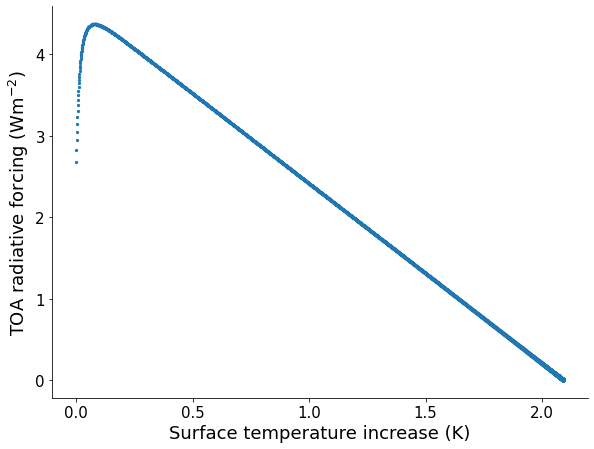

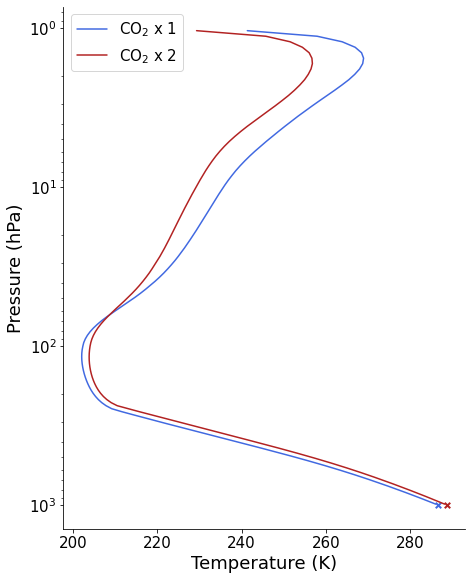

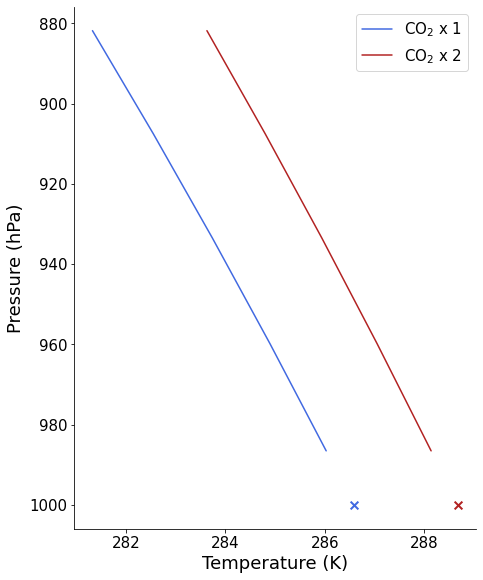

In [24]:
print(max(toa_co2)-66)
print(T_co2_sfc[-1],T_rce_sfc,T_co2_sfc[-1]-T_rce_sfc)
T_anom = T_co2_sfc - T_rce_sfc


#PLOT OLR-Ts dependence
def a(x):
    fig, ax = plt.subplots(figsize=(1.5*6.4, 1.5*4.8))

    ax.scatter(T_anom,OLR_co2-OLR_co2[-1], s=5)

    ax.set_xlabel('Surface temperature increase (K)')
    ax.set_ylabel('OLR anomaly (Wm$^{-2}$)')

    plt.show()


fig, ax = plt.subplots(figsize=(1.5*6.4, 1.5*4.8))

ax.scatter(T_anom,toa_co2-66, s=5)

ax.set_xlabel('Surface temperature increase (K)')
ax.set_ylabel('TOA radiative forcing (Wm$^{-2}$)')

plt.show()



#PLOT whole atmosphere
fig, ax = plt.subplots(figsize=(1.5*4.8, 1.5*6.4))

#ax.plot(T_ini_atm, atmosphere['plev']/100,
#               alpha = 1, color = 'limegreen', lw = 1.5, label = 'Initial temperature')
#ax.scatter(T_ini_sfc, atmosphere['phlev'][0]/100,
#               alpha = 1, color = 'limegreen', s = 60, marker ='x')

ax.plot(T_rce_atm, atmosphere['plev']/100,
               alpha = 1, color = 'royalblue', lw = 1.5, label = 'CO$_2$ x 1')
ax.scatter(T_rce_sfc, atmosphere['phlev'][0]/100,
               alpha = 1, color = 'royalblue', s = 30, marker ='x')
ax.plot(T_co2_atm, atmosphere['plev']/100,
               alpha = 1, color = 'firebrick', lw = 1.5, label = 'CO$_2$ x 2')
ax.scatter(T_co2_sfc[-1], atmosphere['phlev'][0]/100,
               alpha = 1, color = 'firebrick', s = 30, marker ='x')

ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')

plt.legend()
plt.show()

#PLOT near surface atmosphere
fig, ax = plt.subplots(figsize=(1.5*4.8, 1.5*6.4))

#ax.plot(T_ini_atm, atmosphere['plev']/100,
#               alpha = 1, color = 'limegreen', lw = 1.5, label = 'Initial temperature')
#ax.scatter(T_ini_sfc, atmosphere['phlev'][0]/100,
#               alpha = 1, color = 'limegreen', s = 60, marker ='x')

ax.plot(T_rce_atm[:5], atmosphere['plev'][:5]/100,
               alpha = 1, color = 'royalblue', lw = 1.5, label = 'CO$_2$ x 1')
ax.scatter(T_rce_sfc, atmosphere['phlev'][0]/100,
               alpha = 1, color = 'royalblue', s = 60, marker ='x')
ax.plot(T_co2_atm[:5], atmosphere['plev'][:5]/100,
               alpha = 1, color = 'firebrick', lw = 1.5, label = 'CO$_2$ x 2')
ax.scatter(T_co2_sfc[-1], atmosphere['phlev'][0]/100,
               alpha = 1, color = 'firebrick', s = 60, marker ='x')

ax.yaxis.set_inverted(True)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')

plt.legend()
plt.show()

In [22]:
from scipy.stats import linregress
linregress( T_anom[500:], toa_co2[500:])

LinregressResult(slope=-2.2107939378770247, intercept=70.62857880785253, rvalue=-0.9999990481164719, pvalue=0.0, stderr=2.1845422356626417e-05)

first with LH, then with heat sink:
surface T [286.86390019] 286.86375349745487
toa radiation [65.37500208] [65.37531571]
surface radiation 168.309841043547 168.30981184681013
atmosphere radiative cooling [-102.93483896]
latent heat 0.0
sensible heat [102.9011911]
daily evaporation 0.0


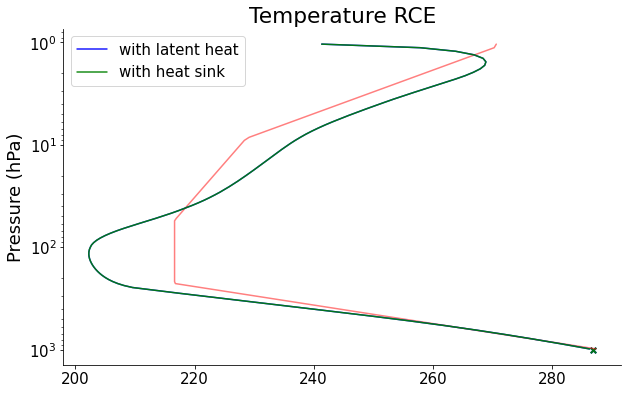

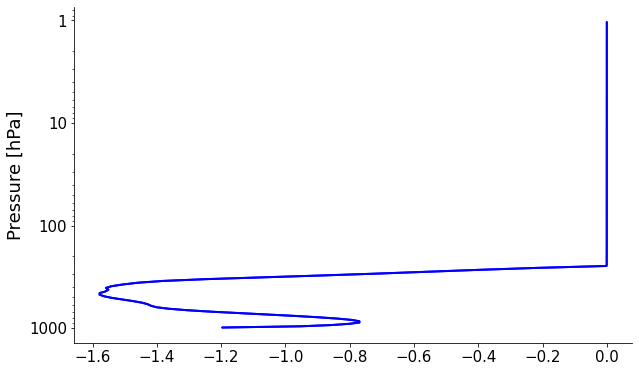

In [7]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG()
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.77),
)

RH = manabe_rh(0.77,atmosphere['plev'])

ndays = 2000
timestep = 0.5 #days
nsteps = int(ndays/timestep)


fig, ax = plt.subplots()
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.5, color = 'red', lw = 1.5)

for i in range(nsteps):
    #update heating rates
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)

    #update net radiaiton at surface
    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
#    SH = sensible_heat(atmosphere['T'][0,0],surface['temperature'],atmosphere['phlev'][0])
    SH = 0.
    
    LH = latent_heat(atmosphere['H2O'][0,0], surface['temperature'],atmosphere['phlev'][0])
    LH = 0.
    
    heat_sink = 66
#    heat_sink = 0.
    
    #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface - LH - SH - heat_sink)
                               * seconds_day * timestep / surface.heat_capacity)
    
    old_T_s = surface['temperature'].copy()
    
    #update atmosphere temperature with energetic fluxes (radiative)
    mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
    atmosphere['T'] += radiation['net_htngrt'] * timestep
    atmosphere['T'][0,0] += SH * seconds_day * timestep / (cp_air * mass_bl)
    
    #temperature of atmosphere after radiative update
    T_radiation = atmosphere['T'][0].copy()
    
    old_T_bl = np.sum(T_radiation[:8])/8
    
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    convection.stabilize(
                atmosphere=atmosphere,
                lapse=lapserate,
                timestep=timestep,
                surface=surface,
            )
    
    SH = (old_T_s - surface['temperature'])*surface.heat_capacity/(timestep*seconds_day)
    wind_speed = SH_to_ws(old_T_bl,old_T_s,atmosphere['phlev'][0],SH)
    
#    plt.plot(wind_speed, i*timestep)

    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'])

    
atmosphere_rce = konrad.atmosphere.Atmosphere(phlev)
surface_rce = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink = 66,
)

humidity_model = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(),
)
rce = konrad.RCE(
    atmosphere_rce,
    surface=surface_rce,  # Run with a fixed surface temperature.
    timestep='12h',  # Set timestep in model time.
    max_duration=ndays, # Set maximum runtime.
    humidity = humidity_model
)
rce.run()

print('first with LH, then with heat sink:')
print('surface T',surface['temperature'],surface_rce['temperature'][0])
print('toa radiation',radiation['toa'],rce.radiation['toa'])
rad_surf_rce = (rce.radiation['lw_flxd'][0,0] + rce.radiation['sw_flxd'][0,0] - 
                    (rce.radiation['lw_flxu'][0,0] + rce.radiation['sw_flxu'][0,0]))
print('surface radiation',net_rad_surface, rad_surf_rce)
print('atmosphere radiative cooling',radiation['toa']-net_rad_surface)
print('latent heat', LH)
print('sensible heat', SH)
print('daily evaporation',energy_to_water(LH)*seconds_day)


ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature RCE')
ax.set_ylabel('Pressure (hPa)')
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'blue', lw = 1.5, label = 'with latent heat')
ax.plot(atmosphere_rce['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'green', lw = 1.5, label = 'with heat sink')
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'blue', s = 30, marker ='x')
ax.scatter(surface_rce['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'green', s = 30, marker ='x')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        radiation['net_htngrt'][0], color = 'blue')
plots.profile_p_log(atmosphere['plev'], 
                        rce.radiation['net_htngrt'][0], color = 'blue')
plt.show()

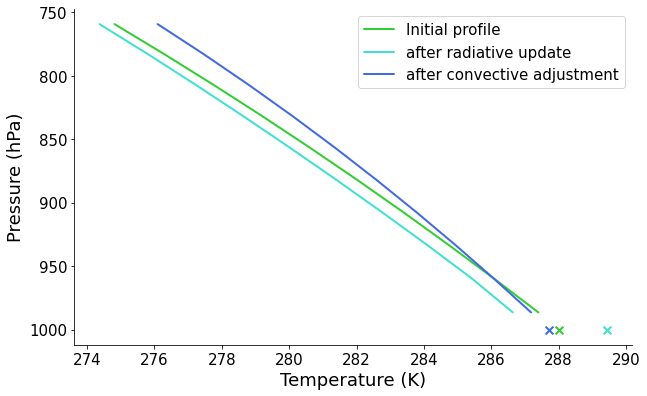

In [12]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
surface.heat_capacity = surface.heat_capacity/50
radiation = konrad.radiation.RRTMG()
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.77),
)

RH = manabe_rh(0.77,atmosphere['plev'])

ndays = 500
timestep = 0.5 #days
nsteps = int(ndays/timestep)


fig, ax = plt.subplots()
ax.plot(atmosphere['T'][0,:10], atmosphere['plev'][:10]/100,
               alpha = 1, color = 'limegreen', lw = 2, label = 'Initial profile')
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 1, color = 'limegreen', s = 60, marker ='x')

#update heating rates
radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)

#update net radiaiton at surface
net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))

#    SH = sensible_heat(atmosphere['T'][0,0],surface['temperature'],atmosphere['phlev'][0])
SH = 0.

LH = latent_heat(atmosphere['H2O'][0,0], surface['temperature'],atmosphere['phlev'][0])
LH = 0.

heat_sink = 66
#    heat_sink = 0.

#update surface temperature with energetic fluxes (latent and radiative)
surface['temperature'] += ((net_rad_surface - LH - SH - heat_sink)
                           * seconds_day * timestep / surface.heat_capacity)



old_T_s = surface['temperature'].copy()

#update atmosphere temperature with energetic fluxes (radiative)
mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
atmosphere['T'] += radiation['net_htngrt'] * timestep
atmosphere['T'][0,0] += SH * seconds_day * timestep / (cp_air * mass_bl)

ax.plot(atmosphere['T'][0,:10], atmosphere['plev'][:10]/100,
               alpha = 1, color = 'turquoise', lw = 2, label = 'after radiative update')
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 1, color = 'turquoise', s = 60, marker ='x')

#temperature of atmosphere after radiative update
T_radiation = atmosphere['T'][0].copy()

old_T_bl = np.sum(T_radiation[:8])/8

#convective adjustment of surface and atmosphere (conserves thermal energy)
convection.stabilize(
            atmosphere=atmosphere,
            lapse=lapserate,
            timestep=timestep,
            surface=surface,
        )

SH = (old_T_s - surface['temperature'])*surface.heat_capacity/(timestep*seconds_day)
wind_speed = SH_to_ws(old_T_bl,old_T_s,atmosphere['phlev'][0],SH)

#    plt.plot(wind_speed, i*timestep)

atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'])



ax.yaxis.set_inverted(True)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')
ax.plot(atmosphere['T'][0,:10], atmosphere['plev'][:10]/100,
               alpha = 1, color = 'royalblue', lw = 2, label = 'after convective adjustment')
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 1, color = 'royalblue', s = 60, marker ='x')

plt.legend()


first with LH, then with heat sink:
surface T [312.04529845] 286.7038853416334
toa radiation [3.49306769] [65.731998]
surface radiation 213.06763265640484 168.2034268283753
atmosphere radiative cooling [-209.57456496]
latent heat 0.0
sensible heat [209.80632727]
daily evaporation 0.0


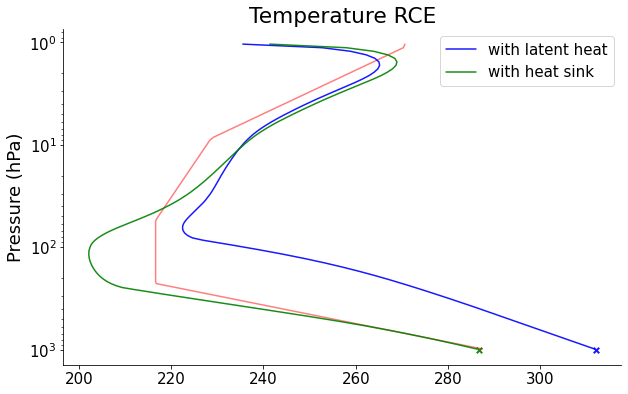

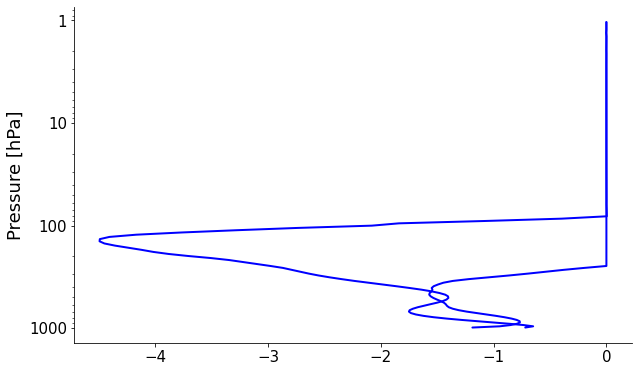

In [9]:
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=66,
    )
radiation = konrad.radiation.RRTMG()
convection = konrad.convection.HardAdjustment()
lapserate = konrad.lapserate.MoistLapseRate()

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.77),
)

RH = manabe_rh(0.77,atmosphere['plev'])

ndays = 3000
timestep = 0.5 #days
nsteps = int(ndays/timestep)


fig, ax = plt.subplots()
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.5, color = 'red', lw = 1.5)

for i in range(nsteps):
    #update heating rates
    radiation.update_heatingrates(atmosphere = atmosphere,surface = surface,cloud=clearsky)

    #update net radiaiton at surface
    net_rad_surface = (radiation['lw_flxd'][0,0] + radiation['sw_flxd'][0,0] - 
                    (radiation['lw_flxu'][0,0] + radiation['sw_flxu'][0,0]))
    
#    SH = sensible_heat(atmosphere['T'][0,0],surface['temperature'],atmosphere['phlev'][0])
    SH = 0.
    
    LH = latent_heat(atmosphere['H2O'][0,0], surface['temperature'],atmosphere['phlev'][0])
    LH = 0.
    
    heat_sink = 0
#    heat_sink = 0.
    
    #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface - LH - SH - heat_sink)
                               * seconds_day * timestep / surface.heat_capacity)
    
    old_T_s = surface['temperature'].copy()
    
    #update atmosphere temperature with energetic fluxes (radiative)
    mass_bl = (atmosphere['phlev'][0]-atmosphere['phlev'][1])/g
    atmosphere['T'] += radiation['net_htngrt'] * timestep
    atmosphere['T'][0,0] += SH * seconds_day * timestep / (cp_air * mass_bl)
    
    #temperature of atmosphere after radiative update
    T_radiation = atmosphere['T'][0].copy()
    
    old_T_bl = np.sum(T_radiation[:8])/8
    
    #convective adjustment of surface and atmosphere (conserves thermal energy)
    convection.stabilize(
                atmosphere=atmosphere,
                lapse=lapserate,
                timestep=timestep,
                surface=surface,
            )
    
    SH = (old_T_s - surface['temperature'])*surface.heat_capacity/(timestep*seconds_day)
    wind_speed = SH_to_ws(old_T_bl,old_T_s,atmosphere['phlev'][0],SH)
    
#    plt.plot(wind_speed, i*timestep)

    atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'])

    
atmosphere_rce = konrad.atmosphere.Atmosphere(phlev)
surface_rce = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink = 66,
)

humidity_model = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(),
)
rce = konrad.RCE(
    atmosphere_rce,
    surface=surface_rce,  # Run with a fixed surface temperature.
    timestep='12h',  # Set timestep in model time.
    max_duration=ndays, # Set maximum runtime.
    humidity = humidity_model
)
rce.run()

print('first with LH, then with heat sink:')
print('surface T',surface['temperature'],surface_rce['temperature'][0])
print('toa radiation',radiation['toa'],rce.radiation['toa'])
rad_surf_rce = (rce.radiation['lw_flxd'][0,0] + rce.radiation['sw_flxd'][0,0] - 
                    (rce.radiation['lw_flxu'][0,0] + rce.radiation['sw_flxu'][0,0]))
print('surface radiation',net_rad_surface, rad_surf_rce)
print('atmosphere radiative cooling',radiation['toa']-net_rad_surface)
print('latent heat', LH)
print('sensible heat', SH)
print('daily evaporation',energy_to_water(LH)*seconds_day)


ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_title('Temperature RCE')
ax.set_ylabel('Pressure (hPa)')
ax.plot(atmosphere['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'blue', lw = 1.5, label = 'with latent heat')
ax.plot(atmosphere_rce['T'][0], atmosphere['plev']/100,
               alpha = 0.9, color = 'green', lw = 1.5, label = 'with heat sink')
ax.scatter(surface['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'blue', s = 30, marker ='x')
ax.scatter(surface_rce['temperature'][0], atmosphere['phlev'][0]/100,
               alpha = 0.9, color = 'green', s = 30, marker ='x')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        radiation['net_htngrt'][0], color = 'blue')
plots.profile_p_log(atmosphere['plev'], 
                        rce.radiation['net_htngrt'][0], color = 'blue')
plt.show()

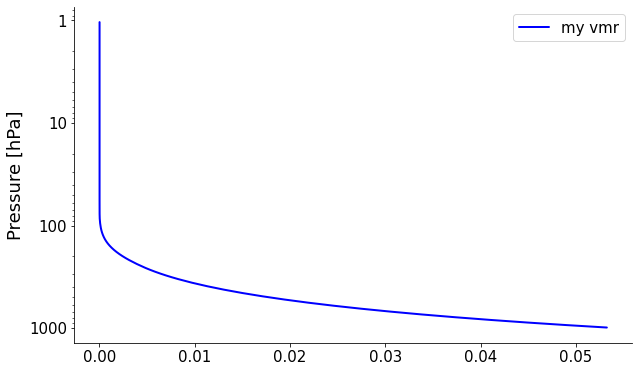

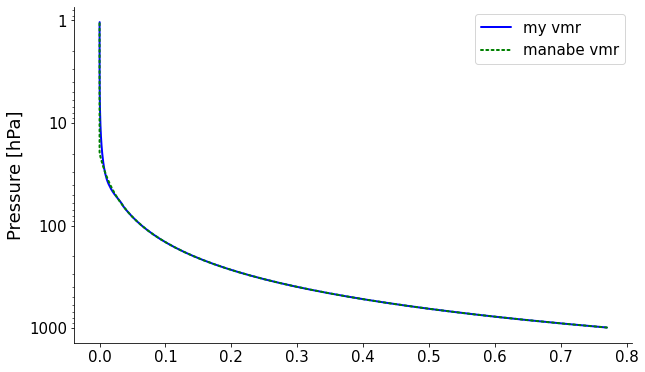

In [10]:
fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        atmosphere['H2O'][0], color = 'blue', label = 'my vmr')
plt.legend()
plt.show()

fig, ax = plt.subplots()
plots.profile_p_log(atmosphere['plev'], 
                        vmr_to_rh(atmosphere['H2O'][0],atmosphere['T'][0],atmosphere['plev']),
                    color = 'blue', label = 'my vmr')
plots.profile_p_log(atmosphere['plev'], RH, 
                    color = 'green', label = 'manabe vmr', linestyle = 'dotted')
plt.legend()
plt.show()

In [11]:
itop = (np.where(np.diff(atmosphere['T'][0])>0)[0][0])
print(atmosphere['T'][0][itop-1], atmosphere['T'][0][itop], atmosphere['T'][0][itop+1])

222.60817734205284 222.4824375324794 222.5241713773915
